## Time Series Forecasting with XGBoost - Part 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('archive/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [3]:
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


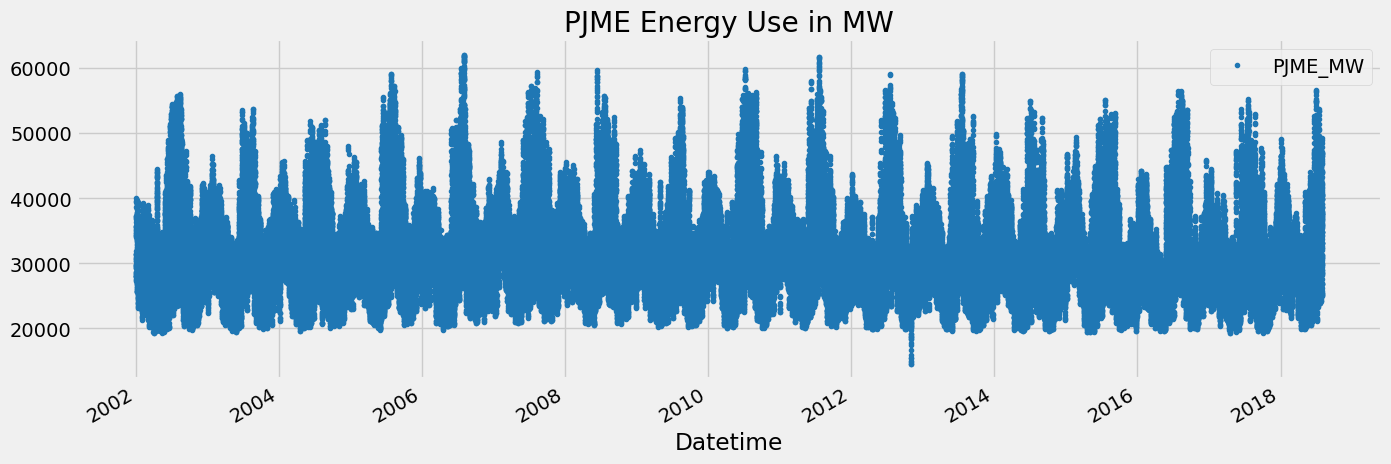

In [4]:
df.plot(style='.',
       figsize=(15,5),
       color=color_pal[0],
       title='PJME Energy Use in MW')
plt.show()

### 1. Outlier Analysis and Removal

<Axes: ylabel='Frequency'>

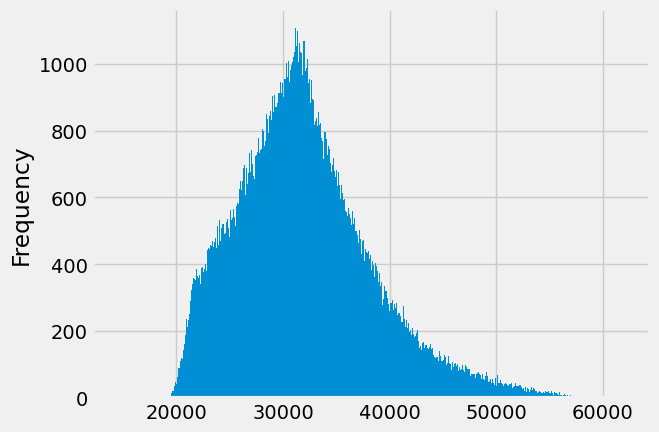

In [5]:
df['PJME_MW'].plot(kind='hist', bins=500)

<Axes: xlabel='Datetime'>

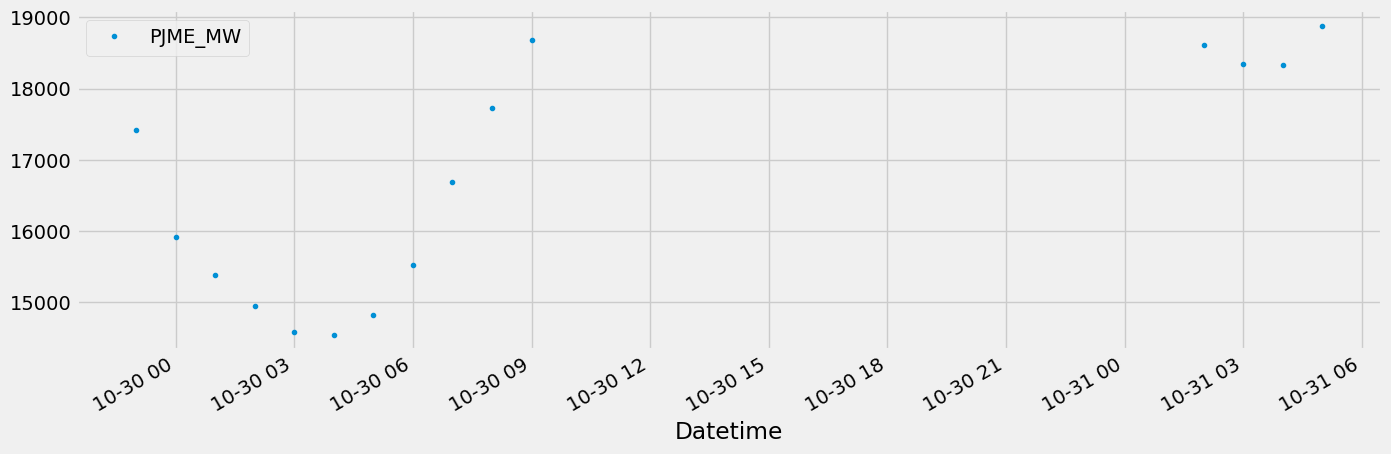

In [8]:
df.query('PJME_MW < 19000').plot(figsize=(15, 5), style='.')

In [9]:
df = df.query('PJME_MW > 19000').copy()

### Reviewing: Train / Test Split

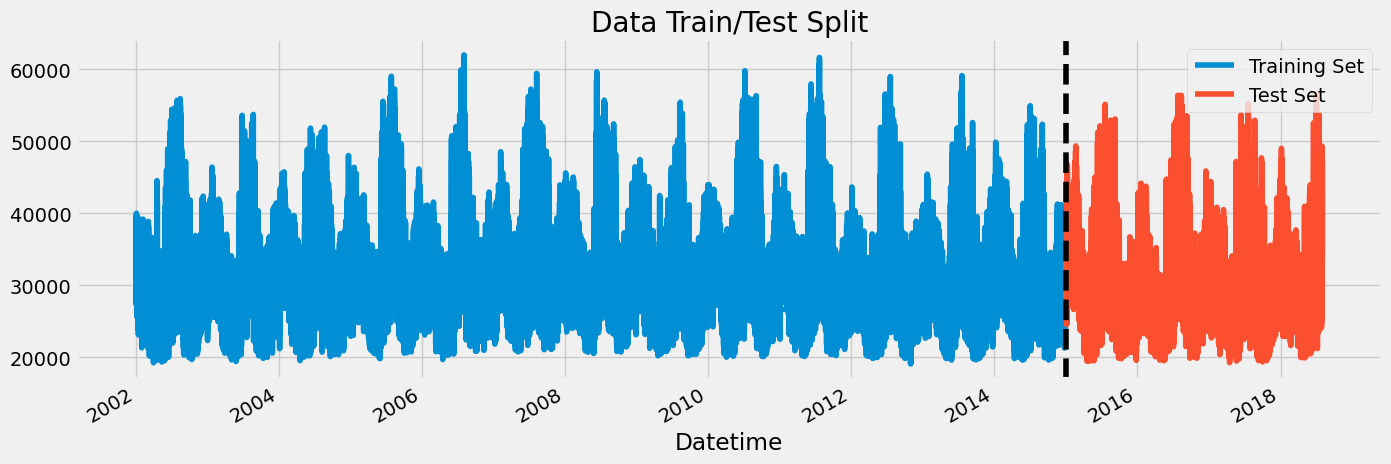

In [10]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label="Training Set", title="Data Train/Test Split")
test.plot(ax=ax, label="Test Set")
ax.axvline("01-01-2015", color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

### 1. Time Series Cross Validation

In [24]:
from sklearn.model_selection import TimeSeriesSplit

In [12]:
tss

TimeSeriesSplit(gap=24, max_train_size=None, n_splits=5, test_size=8760)

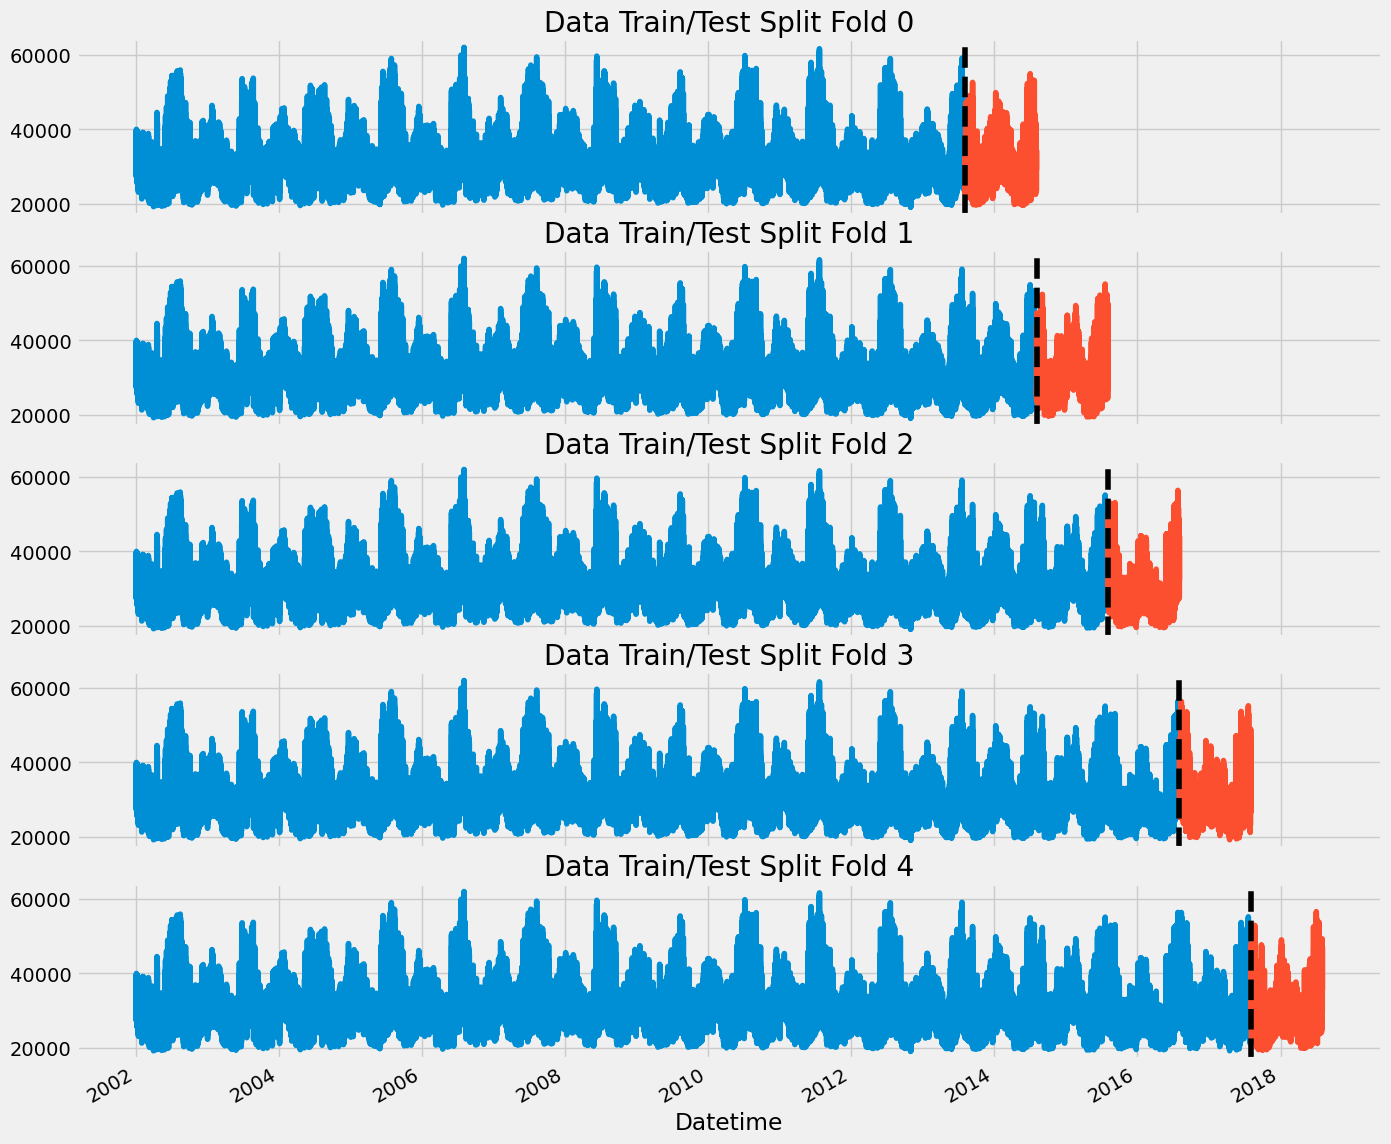

In [14]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                         label='Training Set',
                         title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                       label="Test Set")
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

### 2. Forecasting Horizon Explained

The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term (more than two years).

In [15]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [22]:
df = create_features(df)

### 3. Lag Features

* What was the target (x) days in the past.

In [16]:
target_map = df['PJME_MW'].to_dict()

In [19]:
def add_lags(df):
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [20]:
df = add_lags(df)

#### Train using Cross Validation

In [23]:
df

,PJME_MW,lag1,lag2,lag3,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,NaN,NaN,NaN,1,1,1,1,2002,1
2002-01-01 02:00:00,29265.0,NaN,NaN,NaN,2,1,1,1,2002,1
2002-01-01 03:00:00,28357.0,NaN,NaN,NaN,3,1,1,1,2002,1
2002-01-01 04:00:00,27899.0,NaN,NaN,NaN,4,1,1,1,2002,1
2002-01-01 05:00:00,28057.0,NaN,NaN,NaN,5,1,1,1,2002,1
...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,42256.0,41485.0,38804.0,20,3,3,8,2018,214
2018-08-02 21:00:00,43256.0,41210.0,40249.0,38748.0,21,3,3,8,2018,214
2018-08-02 22:00:00,41552.0,39525.0,38698.0,37330.0,22,3,3,8,2018,214


In [25]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['lag1',	'lag2', 'lag3', 'hour', 'dayofweek' , 'quarter' , 'month', 'year', 'dayofyear']

    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                          n_estimators=1000,
                          early_stopping_rounds=50,
                          objective='reg:linear',
                          max_depth=3,
                          learning_rate=0.01)

    reg.fit(X_train, y_train,
           eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163


/home/aditya/miniconda3/envs/rob-mulla/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [08:34:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1754002079811/work/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12532.64369	validation_1-rmse:11906.14134
[200]	validation_0-rmse:5747.92495	validation_1-rmse:5359.26490
[300]	validation_0-rmse:3872.48134	validation_1-rmse:3900.86965
[400]	validation_0-rmse:3434.23853	validation_1-rmse:3762.33705
[442]	validation_0-rmse:3369.34730	validation_1-rmse:3764.82810
[0]	validation_0-rmse:32672.16678	validation_1-rmse:32138.89241


/home/aditya/miniconda3/envs/rob-mulla/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [08:34:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1754002079811/work/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12513.65574	validation_1-rmse:12224.93373
[200]	validation_0-rmse:5753.34937	validation_1-rmse:5662.07107
[300]	validation_0-rmse:3902.71304	validation_1-rmse:3933.73076
[400]	validation_0-rmse:3476.90515	validation_1-rmse:3590.55005
[500]	validation_0-rmse:3353.72424	validation_1-rmse:3516.39915
[600]	validation_0-rmse:3297.94766	validation_1-rmse:3481.94003
[700]	validation_0-rmse:3258.48267	validation_1-rmse:3461.37383
[800]	validation_0-rmse:3221.51553	validation_1-rmse:3436.49603
[900]	validation_0-rmse:3190.11480	validation_1-rmse:3428.88699
[999]	validation_0-rmse:3166.16314	validation_1-rmse:3420.30469
[0]	validation_0-rmse:32631.20370	validation_1-rmse:31073.29733


/home/aditya/miniconda3/envs/rob-mulla/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [08:34:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1754002079811/work/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12499.28425	validation_1-rmse:11136.70202
[200]	validation_0-rmse:5750.81453	validation_1-rmse:4813.22087
[300]	validation_0-rmse:3917.04200	validation_1-rmse:3553.46419
[400]	validation_0-rmse:3494.55924	validation_1-rmse:3495.32356
[410]	validation_0-rmse:3476.66883	validation_1-rmse:3502.25535
[0]	validation_0-rmse:32528.44438	validation_1-rmse:31475.39670


/home/aditya/miniconda3/envs/rob-mulla/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [08:34:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1754002079811/work/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12462.36581	validation_1-rmse:12020.28283
[200]	validation_0-rmse:5738.57925	validation_1-rmse:5796.45874
[300]	validation_0-rmse:3918.53218	validation_1-rmse:4388.39477
[400]	validation_0-rmse:3501.24270	validation_1-rmse:4173.36380
[500]	validation_0-rmse:3384.02490	validation_1-rmse:4119.69815
[600]	validation_0-rmse:3325.50024	validation_1-rmse:4105.28906
[700]	validation_0-rmse:3282.73755	validation_1-rmse:4091.56819
[800]	validation_0-rmse:3250.37610	validation_1-rmse:4083.46864
[900]	validation_0-rmse:3223.87814	validation_1-rmse:4081.82733
[999]	validation_0-rmse:3199.82843	validation_1-rmse:4053.00719
[0]	validation_0-rmse:32462.05557	validation_1-rmse:31463.90500


/home/aditya/miniconda3/envs/rob-mulla/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [08:34:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1754002079811/work/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12445.87740	validation_1-rmse:11963.42706
[200]	validation_0-rmse:5752.44568	validation_1-rmse:5611.92884
[300]	validation_0-rmse:3951.51709	validation_1-rmse:4156.41403
[400]	validation_0-rmse:3539.25569	validation_1-rmse:4006.58873
[439]	validation_0-rmse:3480.87364	validation_1-rmse:4011.68406


In [26]:
scores

[np.float64(3760.8277187583353),
 np.float64(3420.3046881354244),
 np.float64(3478.018038580526),
 np.float64(4053.0071916504526),
 np.float64(4001.186553933809)]

In [27]:
print(f"Score across folds {np.mean(scores):0.4f}")
print(f"Fold scores: {scores}")

Score across folds 3742.6688
Fold scores: [np.float64(3760.8277187583353), np.float64(3420.3046881354244), np.float64(3478.018038580526), np.float64(4053.0071916504526), np.float64(4001.186553933809)]


### 4. Predicting the Future

* Retraining on all data
* To predict the future we need an empty dataframe for future date ranges.
* Run those dates through our feature creation code + lag creation

In [28]:
# Retrain on all data
df = create_features(df)

FEATURES = ['lag1',	'lag2', 'lag3', 'hour', 'dayofweek' , 'quarter' , 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                      booster='gbtree',
                      n_estimators=500,
                      objective='reg:linear',
                      max_depth=3,
                      learning_rate=0.01)

reg.fit(X_all, y_all,
       eval_set=[(X_all, y_all)],
       verbose=100)

[0]	validation_0-rmse:32403.88991


/home/aditya/miniconda3/envs/rob-mulla/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [08:45:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1754002079811/work/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[100]	validation_0-rmse:12426.82951
[200]	validation_0-rmse:5752.71947
[300]	validation_0-rmse:3971.11520
[400]	validation_0-rmse:3570.41350
[499]	validation_0-rmse:3456.32051


,objective,'reg:linear'
,base_score,0.5
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [29]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [33]:
# Create future dataframe
future = pd.date_range('2018-08-03', '2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])

In [34]:
df_and_future

,PJME_MW,lag1,lag2,lag3,hour,dayofweek,quarter,month,year,dayofyear,isFuture
2002-01-01 01:00:00,30393.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,2002.0,1.0,False
2002-01-01 02:00:00,29265.0,NaN,NaN,NaN,2.0,1.0,1.0,1.0,2002.0,1.0,False
2002-01-01 03:00:00,28357.0,NaN,NaN,NaN,3.0,1.0,1.0,1.0,2002.0,1.0,False
2002-01-01 04:00:00,27899.0,NaN,NaN,NaN,4.0,1.0,1.0,1.0,2002.0,1.0,False
2002-01-01 05:00:00,28057.0,NaN,NaN,NaN,5.0,1.0,1.0,1.0,2002.0,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2019-07-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2019-07-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2019-07-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [35]:
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [36]:
df_and_future

,PJME_MW,lag1,lag2,lag3,hour,dayofweek,quarter,month,year,dayofyear,isFuture
2002-01-01 01:00:00,30393.0,NaN,NaN,NaN,1,1,1,1,2002,1,False
2002-01-01 02:00:00,29265.0,NaN,NaN,NaN,2,1,1,1,2002,1,False
2002-01-01 03:00:00,28357.0,NaN,NaN,NaN,3,1,1,1,2002,1,False
2002-01-01 04:00:00,27899.0,NaN,NaN,NaN,4,1,1,1,2002,1,False
2002-01-01 05:00:00,28057.0,NaN,NaN,NaN,5,1,1,1,2002,1,False
...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,46912.0,39352.0,40243.0,20,2,3,7,2019,212,True
2019-07-31 21:00:00,NaN,45985.0,38699.0,39183.0,21,2,3,7,2019,212,True
2019-07-31 22:00:00,NaN,44094.0,37346.0,37759.0,22,2,3,7,2019,212,True
2019-07-31 23:00:00,NaN,40666.0,34555.0,34641.0,23,2,3,7,2019,212,True


In [37]:
future_w_features = df_and_future.query('isFuture').copy()

In [38]:
future_w_features

,PJME_MW,lag1,lag2,lag3,hour,dayofweek,quarter,month,year,dayofyear,isFuture
2018-08-03 00:00:00,NaN,33539.0,32094.0,31695.0,0,4,3,8,2018,215,True
2018-08-03 01:00:00,NaN,30781.0,29503.0,29128.0,1,4,3,8,2018,215,True
2018-08-03 02:00:00,NaN,29015.0,27712.0,27373.0,2,4,3,8,2018,215,True
2018-08-03 03:00:00,NaN,27884.0,26535.0,26233.0,3,4,3,8,2018,215,True
2018-08-03 04:00:00,NaN,27223.0,25870.0,25643.0,4,4,3,8,2018,215,True
...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,46912.0,39352.0,40243.0,20,2,3,7,2019,212,True
2019-07-31 21:00:00,NaN,45985.0,38699.0,39183.0,21,2,3,7,2019,212,True
2019-07-31 22:00:00,NaN,44094.0,37346.0,37759.0,22,2,3,7,2019,212,True
2019-07-31 23:00:00,NaN,40666.0,34555.0,34641.0,23,2,3,7,2019,212,True


#### Predict the Future

In [39]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

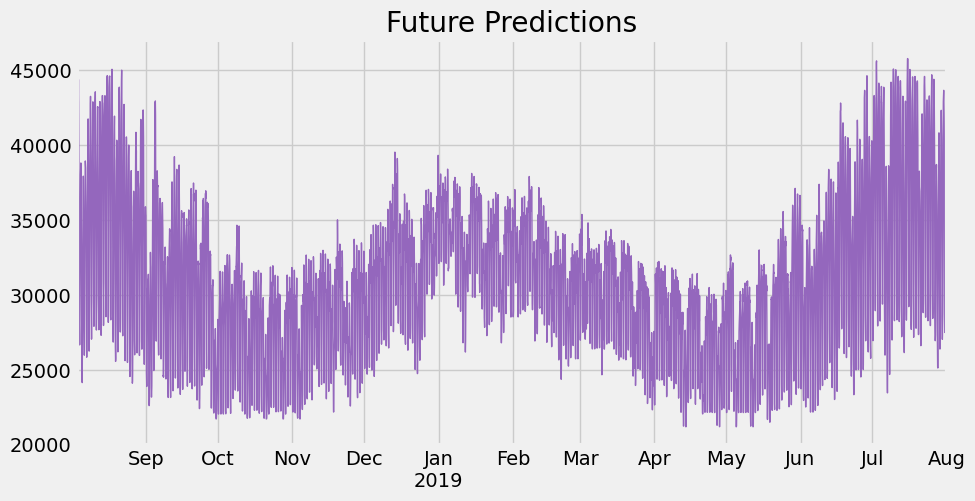

In [40]:
future_w_features['pred'].plot(figsize=(10,5), 
                               color=color_pal[4], 
                               ms=1, 
                               lw=1, 
                               title="Future Predictions")
plt.show()

#### Saving the model for later

In [41]:
reg.save_model('model.json')

In [42]:
!ls -l

total 2120
drwxrwxr-x 2 aditya aditya   4096 Aug  4 10:00 archive
-rw-rw-r-- 1 aditya aditya 572179 Aug  5 08:56 model.json
-rw-rw-r-- 1 aditya aditya 777092 Aug  5 07:15 time-series-forecasting-tutorial-part-1.ipynb
-rw-rw-r-- 1 aditya aditya 813663 Aug  5 08:55 time-series-forecasting-tutorial-part-2.ipynb


In [43]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')

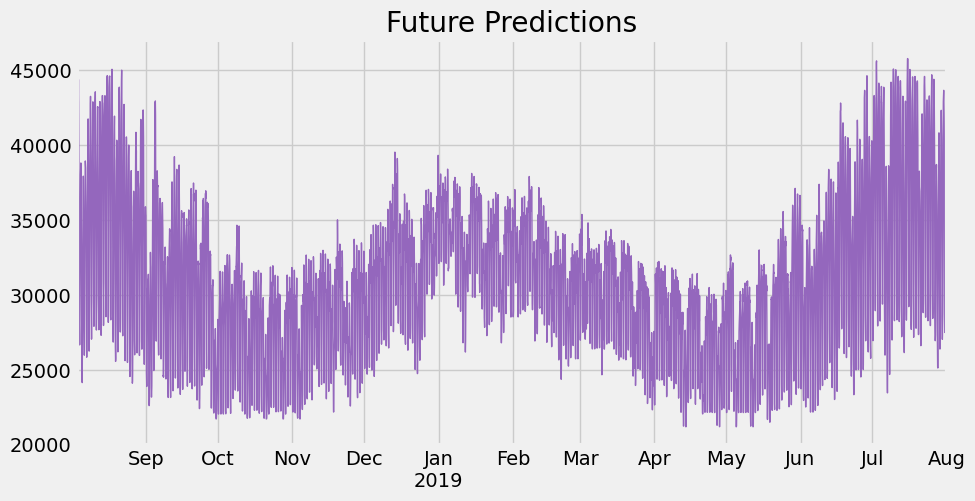

In [45]:
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])

future_w_features['pred'].plot(figsize=(10,5), 
                               color=color_pal[4], 
                               ms=1, 
                               lw=1, 
                               title="Future Predictions")
plt.show()